In [1]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN
from tensorflow.keras.optimizers import RMSprop,Adam
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

Num GPUs Available:  1


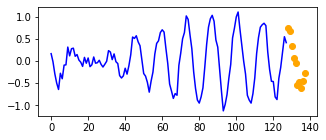

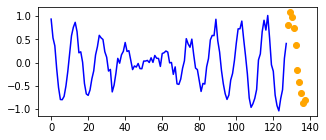

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [2]:


np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
    s = seq_length + look_ahead
    d = np.zeros((size, s,1))
    for i in range(size):
        start = np.random.uniform(0, 2*np.pi) # Random start point
        d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
    return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(2):
    plt.figure(num=None, figsize=(5,2))  
    plt.plot(range(0, seq_length),X[i,:,0],'b-')
    plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')


def slice(x, slice_length):
    return x[:,-slice_length:,:]


In [3]:


model1 = Sequential()
model1.add(Convolution1D(32,5,padding='causal',input_shape=(None,1)))
model1.add(Convolution1D(32,5,padding='causal'))
model1.add(Convolution1D(32,5,padding='causal'))
model1.add(Convolution1D(32,5,padding='causal'))
model1.add(Dense(1))
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
____________________________________________________

---

# Ohne Rauschen lernen (Nicht teil der Aufgabe)

In [4]:
X,Y = gen_data(noise=0.0)


batch_size = 20
epochs = 50
opt = Adam(learning_rate=0.001)
x_train = X[:-200]
y_train = Y[:-200]

x_test = X[-200:]
y_test = Y[-200:]
model1.compile(loss='MSE',
              optimizer=opt,
              metrics=['mse'],)

history = model1.fit(x_train,y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=False)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 2s 2ms/sample - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 2/50
800/800 [==============================] - 0s 207us/sample - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3/50
800/800 [==============================] - 0s 193us/sample - loss: 0.0038 - mse: 0.0038 - val_loss: 2.1504e-04 - val_mse: 2.1504e-04
Epoch 4/50
800/800 [==============================] - 0s 195us/sample - loss: 8.7054e-05 - mse: 8.7054e-05 - val_loss: 1.8024e-05 - val_mse: 1.8024e-05
Epoch 5/50
800/800 [==============================] - 0s 196us/sample - loss: 5.0958e-06 - mse: 5.0958e-06 - val_loss: 5.3773e-07 - val_mse: 5.3773e-07
Epoch 6/50
800/800 [==============================] - 0s 180us/sample - loss: 1.5577e-07 - mse: 1.5577e-07 - val_loss: 7.6340e-09 - val_mse: 7.6340e-09
Epoch 7/50
800/800 [==============================] - 0s 187us/sample - loss: 3.3690

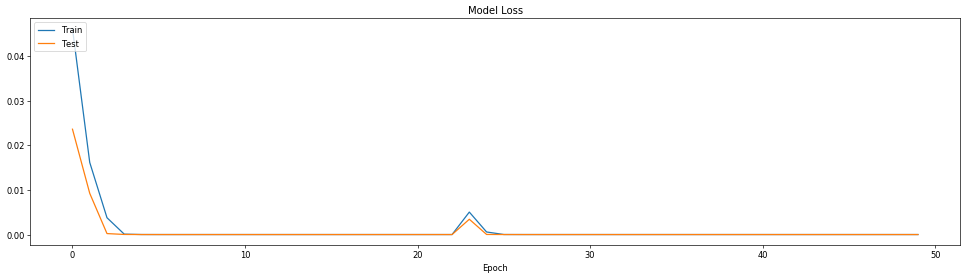

In [5]:
fig, axes = plt.subplots(1, figsize=(20,5),dpi=60, sharex=False, sharey=False)


axes.set_title('Model Loss')
axes.plot(history.history['loss'])
axes.plot(history.history['val_loss'])
axes.set_xlabel('Epoch')
axes.legend(['Train','Test'], loc='upper left')
plt.show()

In [6]:
def predict(model,noise,size=1):

    x_test,y_test = gen_data(size=size,noise=noise)
    for i in range(12):
        predicted = model.predict(x_test ).reshape(-1)#Predicts 10 value
        x_test = np.append(x_test,predicted)
        x_test = x_test.reshape((1,len(x_test),1))

    plt.title("Noise: "+str(noise))
    plt.plot(range(0,len(x_test.reshape(-1))),x_test.reshape(-1))
    plt.axvline(128,color='r')
    plt.show()



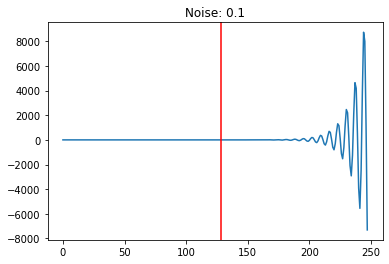

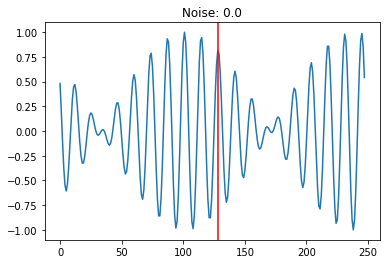

In [7]:
predict(model1,noise=0.1)

predict(model1,noise=0.0)


# Aufgabe A

In [8]:
X,Y = gen_data(noise=0.1)


batch_size = 1
epochs = 50
opt = Adam(learning_rate=0.001)
x_train = X[:-200]
y_train = Y[:-200]

x_test = X[-200:]
y_test = Y[-200:]

model2 = Sequential()
model2.add(Convolution1D(32,5,padding='causal',input_shape=(None,1)))
model2.add(Convolution1D(32,5,padding='causal'))
model2.add(Convolution1D(32,5,padding='causal'))
model2.add(Convolution1D(32,5,padding='causal'))
model2.add(Dense(1))
model2.add(Lambda(slice, arguments={'slice_length':look_ahead}))
model2.summary()

model2.compile(loss='MSE',
              optimizer=opt,
              metrics=['mse'])

history = model2.fit(x_train,y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
__________________________________________________

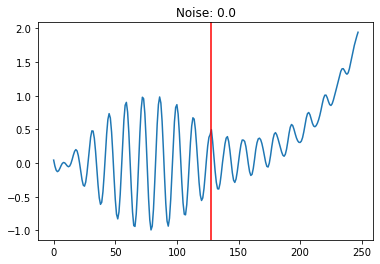

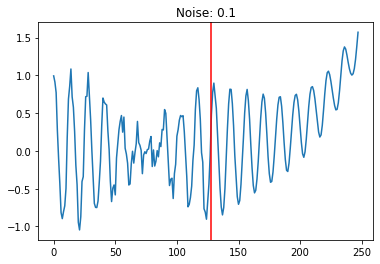

In [9]:
predict(model2,noise=0.0)
predict(model2,noise=0.1)


# Aufgabe B)

In [10]:
look_ahead = 10
seq_length = 128*5
X,Y = gen_data(size=1000,noise=0.1)


batch_size = 20
epochs = 50
opt = Adam(learning_rate=0.001)
x_train = X[:-200]
y_train = Y[:-200]

x_test = X[-200:]
y_test = Y[-200:]


print(x_train.shape)
print(y_train.shape)
model3 = Sequential()
model3.add(Convolution1D(32,5,strides=1,padding='causal',input_shape=(None,1)))
model3.add(Convolution1D(32,5,strides=2,padding='causal'))
model3.add(Convolution1D(32,5,strides=4,padding='causal'))
model3.add(Convolution1D(32,5,strides=8,padding='causal'))
model3.add(Dense(1))
model3.add(Lambda(slice, arguments={'slice_length':look_ahead}))
model3.summary()

model3.compile(loss='MSE',
              optimizer=opt,
              metrics=['mse'])

history = model3.fit(x_train,y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=False)

(800, 640, 1)
(800, 10, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_______________________

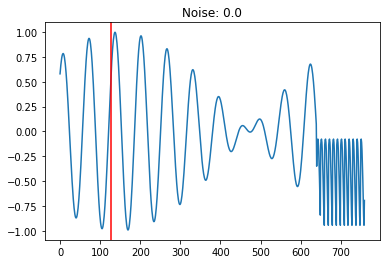

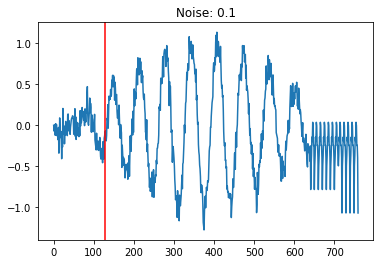

In [11]:
predict(model3,noise=0.0)
predict(model3,noise=0.1)

# MEHR DATEN

In [12]:
look_ahead = 10
seq_length = 128*5
X,Y = gen_data(size=10000,noise=0.1)


batch_size = 20
epochs = 50
opt = Adam(learning_rate=0.001, decay=1e-6)
x_train = X[:-2000]
y_train = Y[:-2000]

x_test = X[-2000:]
y_test = Y[-2000:]


print(x_train.shape)
print(y_train.shape)
model4 = Sequential()
model4.add(Convolution1D(32,5,strides=1,padding='causal',input_shape=(None,1)))
model4.add(Convolution1D(32,5,strides=2,padding='causal'))
model4.add(Convolution1D(32,5,strides=4,padding='causal'))
model4.add(Convolution1D(32,5,strides=8,padding='causal'))
model4.add(Dense(1))
model4.add(Lambda(slice, arguments={'slice_length':look_ahead}))
model4.summary()

model4.compile(loss='MSE',
              optimizer=opt)

history = model4.fit(x_train,y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=False)

(8000, 640, 1)
(8000, 10, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_____________________